# Autoencoder Using CNN

## Preparations
### Load libraries

In [1]:
import numpy as np 
import pandas as pd
import pickle

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Conv2D, Flatten, Input, MaxPool2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers

2025-09-04 19:23:28.920488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-04 19:23:28.920526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-04 19:23:28.921601: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-04 19:23:28.927244: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-04 19:23:29.650609: W tensorflow/compiler/tf2

In [3]:
import tensorflow as tf
tf.random.set_seed(123)
np.random.seed(123)

In [ ]:
# Using 10 epochs will make this notebook run rather quickly.
# If you have time and are willing to wait a bit longer for better results, increase this value to e.g., 50.
nEpochs = 10

### Prepare data

In [4]:
# Load data:
mnist = tf.keras.datasets.mnist
(train_val_images, train_val_labels), (test_images, test_labels) = mnist.load_data()

# Scale image data:
train_val_images = train_val_images / 255.0
test_images = test_images / 255.0

# Split into training / validation
train_images, val_images, train_labels, val_labels = train_test_split(train_val_images, train_val_labels,
                                                                      test_size=0.20, random_state=42)

11490434/11490434 [==============================] - 1s 0us/step


In [5]:
train_val_label_df = pd.DataFrame(train_val_labels)
train_val_label_df.columns = ['label']
train_val_label_df['label'].value_counts()

label
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64

In [6]:
val_label_df = pd.DataFrame(val_labels)
val_label_df.columns = ['label']
val_label_df['label'].value_counts(sort=False, ascending=True)

label
7    1299
3    1219
8    1160
9    1194
5    1104
4    1176
2    1174
6    1177
1    1322
0    1175
Name: count, dtype: int64

## The autoencoder
Every autoencoder consists of two parts: an encoder and a decoder.

* The **encoder** receives the original data (in our case, the black and white images) as input and generates a lower-dimensional code from it.
* The **decoder** receives the code and decodes it into original data (e.g. the images) in the same format as the encoder's inputs.

### Model definition

The two parts put together form the autoencoder:

**Comments on activation functions:**

***Why ReLU?***

* Simplicity and Efficiency: ReLU (Rectified Linear Unit) is computationally efficient because it involves simple thresholding at zero. This makes it faster to compute compared to other activation functions.
* Sparse Activation: ReLU promotes sparsity in the network by setting negative values to zero, which can help in learning more robust features.
* Gradient Propagation: ReLU helps mitigate the vanishing gradient problem, allowing gradients to propagate more effectively during backpropagation.

***Sigmoid*** at the end to get an output between 0 and 1.

In [7]:
CNNmnist_encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")
])

CNNmnist_decoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (7, 7, 64)),
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(16, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(1, kernel_size = (3,3), activation = 'sigmoid', padding = 'same'),
])

CNNmnist_ae = tf.keras.Sequential([CNNmnist_encoder, CNNmnist_decoder])

2025-09-04 19:23:31.976956: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18229 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 2g.20gb, pci bus id: 0001:00:00.0, compute capability: 8.0


### Training
The autoencoder uses unsupervised learning, i.e. we do not pass any predefined labels or similar. Instead, the output should be as similar as possible to the input. We use the squared error as a measure of the quality of the reconstruction.

For a start, we allow a maximum of 10 epochs to train - as with the other convolutional networks (and with deep neural networks in general), you should allow significantly more epochs for real applications.

The training takes a little longer here... With the following code you can save and reload the learned weights - just set `train_from_scratch` as needed.
Please note that only the weights, not the models themselves, are saved and loaded again. The model definition is made in the code and managed as such.

Loading the weights only works if the model definition is exactly the same.

In [8]:
# compile and fit the model
tf.random.set_seed(42) 
CNNmnist_ae.compile(loss="mse", optimizer="nadam")

In [9]:
nPatience = 50

# define paths:
encoder_weights_path_10 = './CNNmnist_encoder_10.weights.h5'
decoder_weights_path_10 = './CNNmnist_decoder_10.weights.h5'
history_path = './CNNmnist_ae.history.h5'

train_from_scratch = True
if train_from_scratch:
    history_ae = CNNmnist_ae.fit(train_images, train_images, epochs=nEpochs, validation_data=(val_images, val_images),
                                 callbacks=[EarlyStopping(monitor='val_loss', patience=nPatience,
                                                          verbose=False, restore_best_weights=True)])
    # Save the weights:
    CNNmnist_encoder.save_weights(encoder_weights_path_10)
    CNNmnist_decoder.save_weights(decoder_weights_path_10)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history_ae, f)
else:
    # load previsously computed weights
    CNNmnist_encoder.load_weights(encoder_weights_path_10)
    CNNmnist_decoder.load_weights(decoder_weights_path_10)
    # connect
    CNNmnist_ae = tf.keras.Sequential([CNNmnist_encoder, CNNmnist_decoder])
    CNNmnist_ae.build(input_shape=(None, 28, 28, 1))

    # load history:
    with open(history_path, 'rb') as f:
        history_ae = pickle.load(f)

Epoch 1/10


2025-09-04 19:23:33.445073: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-09-04 19:23:33.521987: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-09-04 19:23:33.833500: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-09-04 19:23:34.869226: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f93290eb9a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-04 19:23:34.869256: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 2g.20gb, Compute Capability 8.0
2025-09-04 19:23:34.877537: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1757013814.983024     444 device

1500/1500 [==============================] - 9s 4ms/step - loss: 0.0079 - val_loss: 0.0034
Epoch 2/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 3/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 4/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 6/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 7/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 9/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0013 - val_los

Please note that only the weights, not the models themselves, are saved and loaded again. The model definition is made in the code and managed as such.

Loading the weights only works if the model definition is exactly the same.

In [10]:
def plot_history(history):
    """
    Plot model training history.
    Args:
    - history: tensorflow history object.

    Returns:
    None
    """
    plt.plot(history['loss'], label='Training')
    plt.plot(history['val_loss'], label='Validation')
    plt.legend()
    plt.xlabel('Loss history')
    plt.ylabel('Loss')

    plt.show()

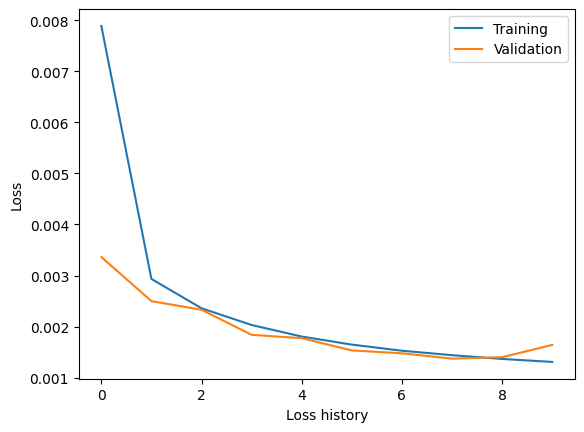

In [11]:
plot_history(history_ae.history)

### Model Summary
We compile the model and can then get a summary of the model:

In [12]:
CNNmnist_ae.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 7, 7, 64)          23296     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         23233     
                                                                 
Total params: 46529 (181.75 KB)
Trainable params: 46529 (181.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
CNNmnist_encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
Total params: 23296 (91.00 KB)
Trainable params: 23296 (

In [14]:
CNNmnist_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 7, 7, 32)          18464     
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 16)        4624      
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 28, 28, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 23233 (90.75 KB)
Trainable params: 23233

This CNN-based model has less than a tenth of the parameters of the network without the convolution layers!

### Looking at the reconstructions
Let's look at some of the reconstructed images:

In [15]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, images=test_images, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
    plt.show()

1/1 [==============================] - 0s 345ms/step


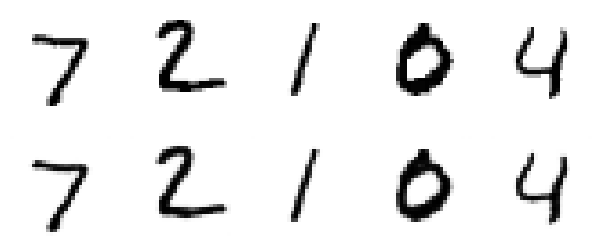

In [16]:
show_reconstructions(CNNmnist_ae)

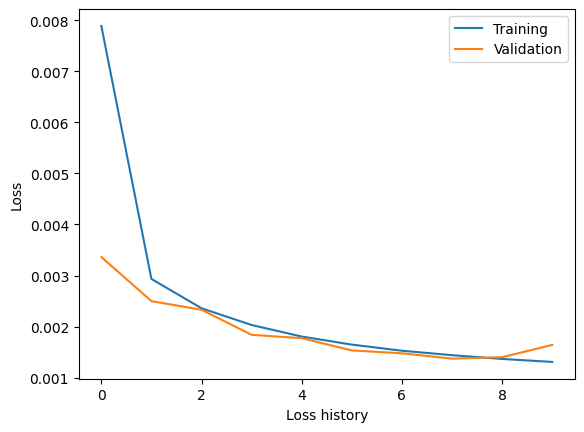

In [17]:
plot_history(history_ae.history)

## Low-dimensional bottleneck autoencoders


### Encoding Dimension 30

In [22]:
CNNmnist_encoder_30 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu')
])

CNNmnist_decoder_30 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(7*7*16, activation= 'relu'),
    tf.keras.layers.Reshape(target_shape = (7, 7, 16)),
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(16, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(1, kernel_size = (3,3), activation = 'sigmoid', padding = 'same'),
])

CNNmnist_ae_30 = tf.keras.Sequential([CNNmnist_encoder_30, CNNmnist_decoder_30])

In [23]:
tf.random.set_seed(42) 
CNNmnist_ae_30.compile(loss="mse", optimizer="nadam")

In [24]:
# define paths:
mnist_encoder_30_path = './CNNmnist_encoder_30.weights.h5'
mnist_decoder_30_path = './CNNmnist_decoder_30.weights.h5'
history_path = './CNNmnist_decoder_30.history.h5'

if train_from_scratch:
    history30 = CNNmnist_ae_30.fit(train_images, train_images, epochs=nEpochs, validation_data=(val_images, val_images),
                                         callbacks=[EarlyStopping(monitor='val_loss', patience=nPatience,
                                                                  verbose=False, restore_best_weights=True)])

    # Save the weights:
    CNNmnist_encoder_30.save_weights(mnist_encoder_30_path)
    CNNmnist_decoder_30.save_weights(mnist_decoder_30_path)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history30, f)

else:
    # load previsously computed weights
    CNNmnist_encoder_30.build(input_shape=(None, 28, 28, 1))
    CNNmnist_decoder_30.build(input_shape=(None, 30))
    CNNmnist_encoder_30.load_weights(mnist_encoder_30_path)
    CNNmnist_decoder_30.load_weights(mnist_decoder_30_path)

    # load history:
    with open(history_path, 'rb') as f:
        history30 = pickle.load(f)

Epoch 1/10
1500/1500 [==============================] - 10s 5ms/step - loss: 0.0222 - val_loss: 0.0126
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0113 - val_loss: 0.0104
Epoch 3/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0096 - val_loss: 0.0090
Epoch 4/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 5/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 6/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 8/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 9/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0071 - val_loss: 0.0073
Epoch 10/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.00

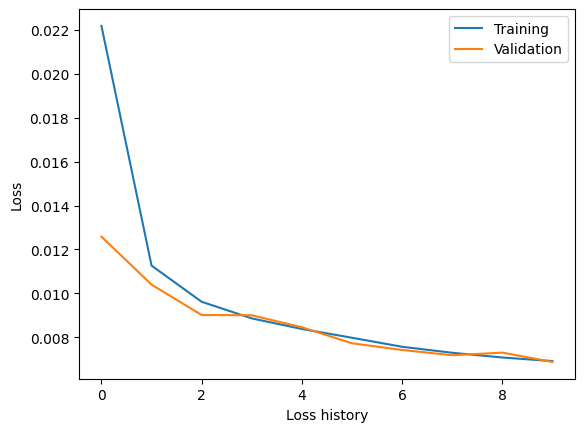

In [25]:
plot_history(history30.history)

1/1 [==============================] - 0s 239ms/step


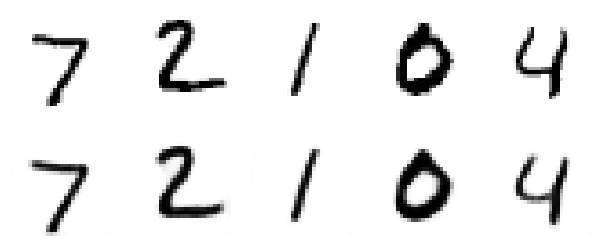

In [26]:
show_reconstructions(CNNmnist_ae_30)

In [27]:
CNNmnist_encoder_30.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 16)          4624      
                                                                 
 flatten_1 (Flatten)         (None, 784)              

In [28]:
CNNmnist_decoder_30.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               3100      
                                                                 
 dense_7 (Dense)             (None, 784)               79184     
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 16)          0         
                                                                 
 conv2d_15 (Conv2D)          (None, 7, 7, 32)          4640      
                                                                 
 up_sampling2d_4 (UpSamplin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 16)        4624      
                                                      

### Encoding Dimension 2

**TODO**: Implement an autoencoder with an encoding dimension of 2. Follow the above example with an encoding dimension of 30.

In [ ]:
# Model definition
# CNNmnist_encoder_2 = ...
# 
# CNNmnist_decoder_2 = ...
# 
# CNNmnist_ae_2 = ...

tf.random.set_seed(42) 
CNNmnist_ae_2.compile(loss="mse", optimizer="nadam")

**Solution**:

In [31]:
# Model definition
CNNmnist_encoder_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(), # input_shape: 7 x 7 x 16
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(2)
])

CNNmnist_decoder_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(7*7*16, activation= 'relu'),
    tf.keras.layers.Reshape(target_shape = (7, 7, 16)),
    tf.keras.layers.Conv2D(8, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(8, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(1, kernel_size = (3,3), activation = 'sigmoid', padding = 'same'),
])

CNNmnist_ae_2 = tf.keras.Sequential([CNNmnist_encoder_2, CNNmnist_decoder_2])

tf.random.set_seed(42) 
CNNmnist_ae_2.compile(loss="mse", optimizer="nadam")

**(End of Solution)**

In [32]:
# define paths:
mnist_encoder_2_path = './CNNmnist_encoder_2.weights.h5'
mnist_decoder_2_path = './CNNmnist_decoder_2.weights.h5'
history_path = './CNNmnist_decoder_2.history.h5'

if train_from_scratch:
    history2 = CNNmnist_ae_2.fit(train_images, train_images, epochs=nEpochs, validation_data=(val_images, val_images),
                                       callbacks=[EarlyStopping(monitor='val_loss', patience=nPatience,
                                                                verbose=False, restore_best_weights=True)])

    # Save the weights:
    CNNmnist_encoder_2.save_weights(mnist_encoder_2_path)
    CNNmnist_decoder_2.save_weights(mnist_decoder_2_path)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history2, f)

else:
    # load previsously computed weights
    CNNmnist_encoder_2.build(input_shape=(None, 28, 28, 1))
    CNNmnist_decoder_2.build(input_shape=(None, 2))
    CNNmnist_encoder_2.load_weights(mnist_encoder_2_path)
    CNNmnist_decoder_2.load_weights(mnist_decoder_2_path)

    # load history:
    with open(history_path, 'rb') as f:
        history2 = pickle.load(f)

Epoch 1/10
1500/1500 [==============================] - 10s 5ms/step - loss: 0.0544 - val_loss: 0.0461
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0441 - val_loss: 0.0425
Epoch 3/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0418 - val_loss: 0.0411
Epoch 4/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0406 - val_loss: 0.0400
Epoch 5/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0398 - val_loss: 0.0394
Epoch 6/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0392 - val_loss: 0.0390
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0388 - val_loss: 0.0387
Epoch 8/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0385 - val_loss: 0.0384
Epoch 9/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0382 - val_loss: 0.0383
Epoch 10/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.03

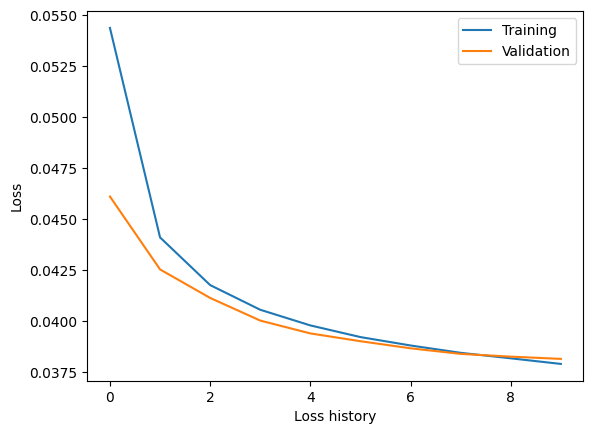

In [33]:
plot_history(history2.history)

1/1 [==============================] - 0s 355ms/step


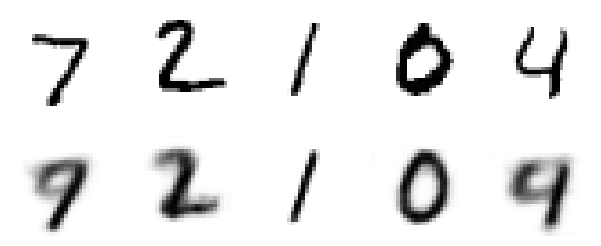

In [34]:
show_reconstructions(CNNmnist_ae_2)

### Visualizing Decodings
In the following, we will see how a few chosen codes will be decoded into an image:

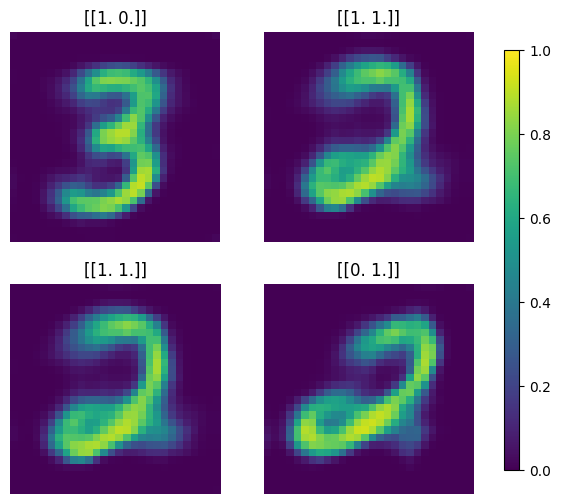

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for ID1 in range(2):
    for ID2 in range(2):
        code = np.zeros(shape=[1, 2])
        code[0, ID1] = 1
        code[0, ID2] = 1
        coding = np.squeeze(CNNmnist_decoder_2(code))
        im = axs[ID1, ID2].imshow(coding, vmin=0, vmax=1)
        axs[ID1, ID2].axis('off')
        axs[ID1, ID2].set_title(code)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

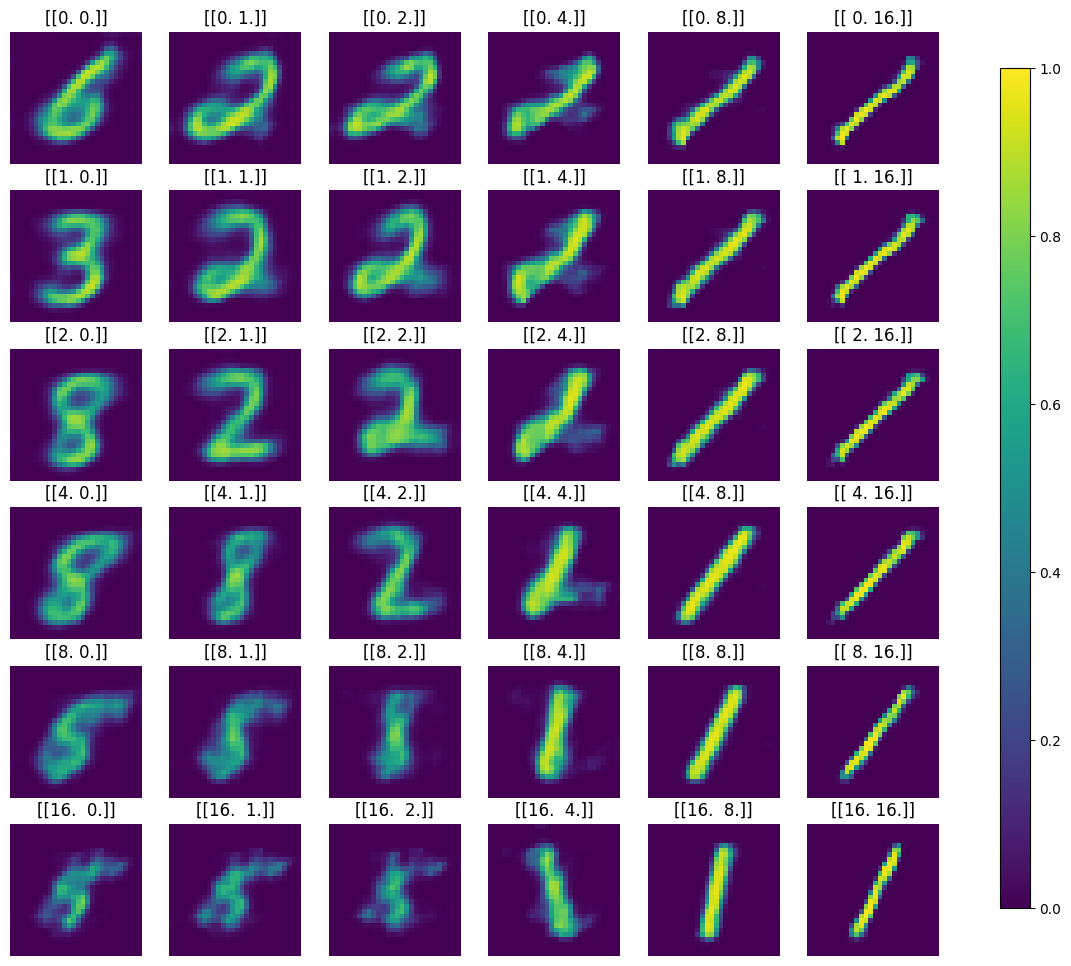

In [36]:
fig, axs = plt.subplots(6, 6, figsize=(12, 12))

for val1 in np.linspace(0, 5, 6):
    for val2 in np.linspace(0, 5, 6):
        code = np.zeros(shape=[1, 2])
        if val1>0:
            code[0, 0] = 2**(val1-1)
        if val2>0:
            code[0, 1] = 2**(val2-1)
        coding = np.squeeze(CNNmnist_decoder_2(code))
        im = axs[int(val1), int(val2)].imshow(coding, vmin=0, vmax=1)
        axs[int(val1), int(val2)].axis('off')
        axs[int(val1), int(val2)].set_title(code)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

### Visualizing Encodings
Having 2 dimensions is a very good starting points for visualization: We can look at where in the 2D code space the images representing the individual digits are projected to:

In [37]:
val_encodings2 = CNNmnist_encoder_2.predict(val_images, batch_size=256)

47/47 [==============================] - 0s 5ms/step


In [38]:
val_encodings2.shape

(12000, 2)

In [39]:
val_encodings2[:10,:]

array([[ 7.706085  , -5.4731603 ],
       [ 0.73467594, -0.10305505],
       [ 2.8471096 ,  0.24134405],
       [15.263458  , -6.0228505 ],
       [ 0.73611176,  0.38032478],
       [ 8.823223  , -5.298899  ],
       [ 7.9531474 , -4.414445  ],
       [10.223732  , -5.586758  ],
       [ 1.1283777 , -0.65645444],
       [ 7.638631  , -7.144448  ]], dtype=float32)

In [40]:
sparseAE_embedding = pd.DataFrame(val_encodings2)
sparseAE_embedding.columns = ['Dimension 1', 'Dimension 2']
sparseAE_embedding['label'] = val_labels

In [41]:
sparseAE_embedding.shape

(12000, 3)

In [42]:
val_labels.shape

(12000,)

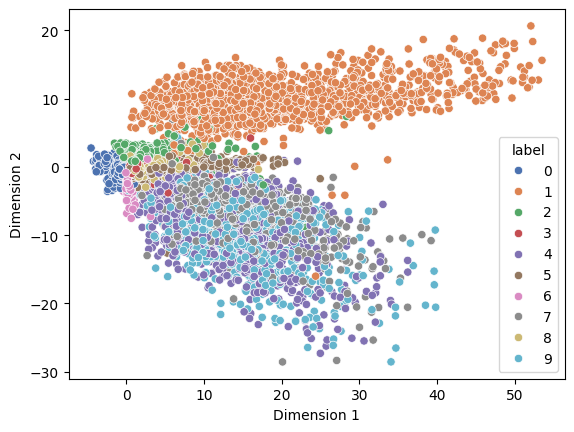

In [45]:
sns.scatterplot(sparseAE_embedding, x='Dimension 1', y='Dimension 2', hue='label', legend='full', palette='deep')
plt.show()

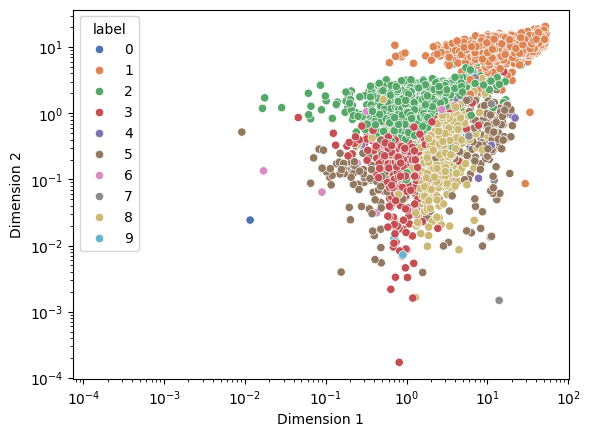

In [46]:
sns.scatterplot(sparseAE_embedding, x='Dimension 1', y='Dimension 2', hue='label', legend='full', palette='deep')
plt.xscale('log')
plt.yscale('log')
plt.show()

**TODO:** Given the above graph, can you find a code that will be decoded into an image representing the digit "0"? Use the above two plots as basis for your guess, and adapt the below code cell to verify your finding.

In [ ]:
code = np.zeros(shape=[1, 2])
# modify the values of the first and second dimension
# code[0, 0] = ...
# code[0, 1] = ...
coding = np.squeeze(CNNmnist_decoder_2(code))
plt.imshow(coding, vmin=0, vmax=1)
plt.axis('off')
plt.title(code)
plt.show()

**Solution:**

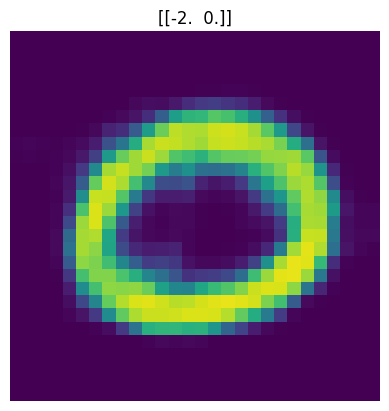

In [65]:
code = np.zeros(shape=[1, 2])
# modify the values of the first and second dimension
code[0, 0] = -2
code[0, 1] =  0
coding = np.squeeze(CNNmnist_decoder_2(code))
plt.imshow(coding, vmin=0, vmax=1)
plt.axis('off')
plt.title(code)
plt.show()

**(End of Solution)**